## Autonomous Multi-Agent System for Enhanced Automotive User Experience

#### Capstone Project - Kaggle 5-Day Generative AI Course

In [1]:
!pip uninstall -qqy kfp jupyterlab google-generativeai tensorflow-hub 2>/dev/null
!pip install -U -q langchain langchain-google-genai langgraph google-cloud-aiplatform pandas scikit-learn "langchain-community>=0.2.7" "langchain-core>=0.2.19"
!pip install -U -q google-cloud-speech
!pip install chromadb
!pip install "protobuf==3.20.3" -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 91.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.3/423.3 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 10.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take 

In [2]:
import os
import typing
import uuid
import math
import heapq
from collections.abc import Iterable
from random import randint
from pprint import pprint

from langchain_core.messages.ai import AIMessage
from langchain_core.messages.human import HumanMessage
from langchain_core.messages.tool import ToolMessage
from langchain_core.tools import tool
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain.vectorstores import Chroma
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.documents import Document

from google.cloud import aiplatform
from langchain_community.embeddings import VertexAIEmbeddings
from langchain_community.vectorstores.matching_engine import MatchingEngine

from IPython.display import Image, display, Markdown

from typing import Annotated, Literal
from typing_extensions import TypedDict

In [3]:
from kaggle_secrets import UserSecretsClient

user_secrets = UserSecretsClient()
GOOGLE_API_KEY = user_secrets.get_secret("GOOGLE_API_KEY")
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

In [4]:
PROJECT_ID = "capstone-project"
LOCATION = "us-central1"

try:
    aiplatform.init(project=PROJECT_ID, location=LOCATION)
    print(f"Vertex AI initialized for project {PROJECT_ID} in {LOCATION}.")
except Exception as e:
    print(f"Error initializing Vertex AI: {e}")

Vertex AI initialized for project capstone-project in us-central1.


In [5]:
car_manual_text = """
## Headlights

### Automatic Headlights
Your vehicle is equipped with automatic headlights. To enable this feature, rotate the headlight switch stalk (usually on the left of the steering wheel) to the 'AUTO' position. The headlights will then turn on automatically in low light conditions or when wipers are activated.

### Manual Headlight Operation
To operate the headlights manually, rotate the switch stalk:
- One click clockwise: Parking lights only.
- Two clicks clockwise: Low beam headlights.
- Pull the stalk towards you: High beam headlights (may flash or stay on depending on previous state). Push away to return to low beams.

## Tire Pressure Monitoring System (TPMS)

### Checking Tire Pressure
Your vehicle's recommended tire pressure is listed on the sticker inside the driver's side doorjamb. For most models, it is typically 35 PSI when tires are cold. Use a reliable pressure gauge to check pressure regularly, ideally monthly.

### TPMS Warning Light
If the TPMS warning light (often looks like a tire cross-section with an exclamation mark) illuminates on your dashboard, it indicates one or more tires are significantly under-inflated. Check all tire pressures as soon as possible and inflate them to the recommended PSI. The light may take some driving to reset after inflation. If the light flashes, it usually indicates a system malfunction; consult your dealer.

## Bluetooth Pairing

### Pairing a New Device
1. Ensure Bluetooth is enabled on your phone or audio device.
2. On the vehicle's infotainment screen, navigate to Settings > Bluetooth > Add Device.
3. The system will search for nearby devices. Select your device from the list.
4. A pairing code may be displayed on both the screen and your device. Confirm they match.
5. Accept the pairing request on your device.
6. Once paired, you can select the device for audio playback or phone calls.

### Troubleshooting Pairing
If pairing fails, try turning Bluetooth off and on again on both the vehicle and your device. Ensure your device is discoverable. Delete old pairings if you have reached the maximum number of devices. Consult the infotainment system manual for more detailed steps.

## Wipers

### Front Wipers
The wiper control stalk is typically on the right side of the steering column.
- Push down once for a single wipe (mist).
- Pull up one click for intermittent wipers. Rotate the band to adjust the delay.
- Pull up two clicks for low speed continuous wipers.
- Pull up three clicks for high speed continuous wipers.
- Push the end button to spray washer fluid on the front windshield.

### Rear Wiper (if equipped)
Usually controlled by twisting the end cap of the right stalk.
- Twist forward one position for intermittent rear wipe.
- Twist forward two positions for continuous rear wipe.
- Push the stalk away from you to spray rear washer fluid.
"""
try:
    gemini_embeddings = GoogleGenerativeAIEmbeddings(model="models/text-embedding-004", task_type="retrieval_document")
except Exception as e:
    print(f"Error initializing Gemini Embeddings via LangChain: {e}")
    gemini_embeddings = None

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50
)
doc_splits = [Document(page_content=chunk, metadata={"source": "local_manual"})
              for chunk in text_splitter.split_text(car_manual_text)]
print(f"Created {len(doc_splits)} document chunks.")

vector_store = None
if gemini_embeddings and doc_splits:
    try:
        print("Creating in-memory ChromaDB vector store and adding documents...")
        vector_store = Chroma.from_documents(
            documents=doc_splits,
            embedding=gemini_embeddings,
        )
        print("ChromaDB vector store created successfully.")
    except Exception as e:
        print(f"Error creating ChromaDB vector store: {e}")
else:
    print("Skipping vector store creation due to previous errors or no documents.")

retriever = None
if vector_store:
    retriever = vector_store.as_retriever(search_kwargs={"k": 3})
    print("ChromaDB retriever created.")

Created 8 document chunks.
Creating in-memory ChromaDB vector store and adding documents...
ChromaDB vector store created successfully.
ChromaDB retriever created.


In [6]:
locations = {
    "Home": {"type": "residence", "x": 0, "y": 0},
    "Downtown Cafe": {"type": "coffee shop", "x": 10, "y": 5},
    "Tech Park Cafe": {"type": "coffee shop", "x": 45, "y": 35},
    "Main St Gas": {"type": "gas station", "x": 12, "y": 0},
    "Highway Gas Stop": {"type": "gas station", "x": 50, "y": 50},
    "Luigi's Pizza": {"type": "restaurant", "x": 9, "y": 8},
    "Ocean Sushi": {"type": "restaurant", "x": 25, "y": 18},
    "City Hall": {"type": "government", "x": 20, "y": 20},
    "Shopping Mall": {"type": "shopping", "x": 22, "y": 22},
    "Tech Park Work": {"type": "office", "x": 40, "y": 30},
    "Park Entrance": {"type": "park", "x": 18, "y": 25},
    "Library": {"type": "government", "x": 19, "y": 19}
}

connections = {
    "Home": {"Main St Gas": 12, "Downtown Cafe": 11, "Luigi's Pizza": 12},
    "Main St Gas": {"Home": 12, "Downtown Cafe": 2, "City Hall": 10},
    "Downtown Cafe": {"Home": 11, "Main St Gas": 2, "Luigi's Pizza": 1},
    "Luigi's Pizza": {"Downtown Cafe": 1, "Ocean Sushi": 16, "Library": 13},
    "City Hall": {"Main St Gas": 10, "Library": 1, "Shopping Mall": 2, "Park Entrance": 6, "Ocean Sushi": 7},
    "Library": {"Luigi's Pizza": 13, "City Hall": 1},
    "Shopping Mall": {"City Hall": 2, "Park Entrance": 3, "Ocean Sushi": 5},
    "Park Entrance": {"City Hall": 6, "Shopping Mall": 3, "Tech Park Work": 15},
    "Ocean Sushi": {"Luigi's Pizza": 16, "City Hall": 7, "Shopping Mall": 5, "Tech Park Work": 18},
    "Tech Park Work": {"Ocean Sushi": 18, "Park Entrance": 15, "Tech Park Cafe": 5, "Highway Gas Stop": 12},
    "Tech Park Cafe": {"Tech Park Work": 5, "Highway Gas Stop": 10},
    "Highway Gas Stop": {"Tech Park Cafe": 10, "Tech Park Work": 12}
}

nodes_to_update = {}
for node, neighbours in connections.items():
    for neighbour, distance in neighbours.items():
        if neighbour not in connections:
             nodes_to_update[neighbour] = {}
        if node not in connections.get(neighbour, {}):
             if neighbour not in nodes_to_update: nodes_to_update[neighbour] = {}
             nodes_to_update[neighbour][node] = distance
connections.update(nodes_to_update)

current_location_name = "Home"

def find_shortest_path(graph, start, end):
    """Finds the shortest path between start and end nodes using Dijkstra."""
    distances = {node: float('inf') for node in graph}
    distances[start] = 0
    previous_nodes = {node: None for node in graph}
    priority_queue = [(0, start)]

    while priority_queue:
        current_distance, current_node = heapq.heappop(priority_queue)

        if current_distance > distances[current_node]:
            continue

        if current_node == end:
            break

        if current_node not in graph:
             continue

        for neighbor, weight in graph[current_node].items():
            distance = current_distance + weight
            if distance < distances[neighbor]:
                distances[neighbor] = distance
                previous_nodes[neighbor] = current_node
                heapq.heappush(priority_queue, (distance, neighbor))

    path = []
    current = end
    if distances[current] == float('inf'):
        return None, float('inf')

    while current is not None:
        path.append(current)
        current = previous_nodes[current]
    path.reverse()

    return path, distances[end]

In [7]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    current_request: str | None
    last_agent_response: str | None
    route_decision: Literal["Navigation", "Media", "Communication", "VehicleInfo", "Respond", "Error", None]
    vehicle_context: list[str] | None
    navigation_context: dict | None
    media_context: dict | None
    communication_context: dict | None
    error: str | None
    final_response_generated: bool

## Tools

In [8]:
@tool
def navigation_tool(action: str, destination: str | None = None, poi_type: str | None = None) -> str:
    """
    Handles navigation tasks using a local graph map dataset.
    Actions: 'find_poi', 'start_navigation', 'get_traffic'.
    Requires 'poi_type' for 'find_poi' (e.g., 'coffee shop', 'gas station').
    Requires 'destination' name (must match a key in the 'locations' dictionary) for 'start_navigation'.
    'get_traffic' action is simplified.
    """
    print(f"--- TOOL CALL: navigation_tool (Action: {action}, Destination: {destination}, POI: {poi_type}) ---")
    global current_location_name
    global locations
    global connections

    current_loc_details = locations.get(current_location_name)
    if not current_loc_details:
        return "Error: Current location unknown or invalid."
    current_x = current_loc_details["x"]
    current_y = current_loc_details["y"]

    try:
        if action == "find_poi":
            if poi_type:
                found_pois = []
                poi_type_lower = poi_type.lower()
                for name, details in locations.items():
                    if details["type"] == poi_type_lower:
                        path, distance = find_shortest_path(connections, current_location_name, name)
                        if path:
                            found_pois.append({"name": name, "distance": distance, "path": path})

                if not found_pois:
                    return f"Sorry, I couldn't find any reachable '{poi_type}' from {current_location_name} using the available roads."

                found_pois.sort(key=lambda p: p["distance"])
                nearest_poi = found_pois[0]
                return (f"Found '{poi_type}': '{nearest_poi['name']}' is the closest reachable one "
                        f"(distance: {nearest_poi['distance']:.1f} units via {', '.join(nearest_poi['path'])}).")
            else:
                 return "Error: Please specify a type of place (POI) to find (e.g., 'coffee shop')."

        elif action == "start_navigation":
            if destination:
                if destination == current_location_name:
                    return f"You are already at {destination}."

                if destination in locations:
                    path, distance = find_shortest_path(connections, current_location_name, destination)
                    if path:
                        current_location_name = destination
                        print(f"   INFO: Simulating navigation. Current location updated to {destination}")
                        first_step = path[1] if len(path) > 1 else destination
                        return (f"Starting navigation to {destination}. "
                                f"Estimated travel distance: {distance:.1f} units. "
                                f"Route: {', '.join(path)}. First head towards {first_step}.")
                    else:
                        return f"Sorry, I couldn't find a route in the local map data from {current_location_name} to {destination}."
                else:
                    return f"Sorry, I don't have '{destination}' in my local map data."
            else:
                 return "Error: Please specify a destination for navigation."

        elif action == "get_traffic":
             if destination:
                 if destination in locations:
                      path, distance = find_shortest_path(connections, current_location_name, destination)
                      if distance > 20:
                          return f"Simulated: Traffic towards {destination} looks heavy based on distance."
                      else:
                          return f"Simulated: Traffic towards {destination} looks moderate."
                 else:
                     return f"Cannot check traffic for unknown destination: {destination}"
             else:
                 return "Simulated: Traffic in the current area appears moderate."

        else:
            return f"Error: Invalid navigation action '{action}'. Use 'find_poi', 'start_navigation', or 'get_traffic'."

    except Exception as e:
        print(f"   ERROR during local navigation tool execution: {e}")
        return f"Sorry, I encountered an internal error using the local navigation tool."


@tool
def media_tool(action: str, query: str | None = None) -> str:
    """
    Simulates interaction with a Media API.
    Actions can be 'play', 'pause', 'search_music', 'search_podcast'.
    Requires query for search actions.
    """
    print(f"--- TOOL CALL: media_tool (Action: {action}, Query: {query}) ---")
    if action == "play" and query:
        return f"Simulated: Playing '{query}'."
    elif action == "play":
        return f"Simulated: Resuming playback."
    elif action == "pause":
        return "Simulated: Pausing media."
    elif action == "search_music" and query:
        return f"Simulated: Found music matching '{query}'."
    elif action == "search_podcast" and query:
         return f"Simulated: Found podcasts matching '{query}'."
    else:
        return "Simulated: Invalid media action or missing query."

@tool
def communication_tool(action: str, recipient: str | None = None, message: str | None = None) -> str:
    """
    Simulates interaction with a Communication API (e.g., SMS, Email).
    Actions can be 'send_message', 'read_last_message'.
    Requires recipient and message for 'send_message'.
    """
    print(f"--- TOOL CALL: communication_tool (Action: {action}, Recipient: {recipient}) ---")
    if action == "send_message" and recipient and message:
        return f"Simulated: Sending message '{message}' to {recipient}."
    elif action == "read_last_message":
        return "Simulated: Last message reads 'On my way!'"
    else:
        return "Simulated: Invalid communication action or missing parameters."

@tool
def get_vehicle_info(query: str) -> str:
    """
    Provides information about the vehicle's features and functions by
    searching the local car manual vector store using RAG. Use this for
    questions about how to operate the car or troubleshoot issues.
    """
    print(f"--- TOOL CALL: get_vehicle_info (Query: {query}) ---")
    global retriever

    if not retriever:
        print("   ERROR: Local vector store retriever is not available.")
        return "Error: The vehicle information system (manual search) is currently unavailable."

    try:
        print(f"   Searching local vector store for: '{query}'")
        relevant_docs = retriever.invoke(query)

        if not relevant_docs:
             print("   No relevant documents found in local store.")
             return "I looked through the manual, but couldn't find specific information for that query."

        context = "\n\n---\n\n".join([doc.page_content for doc in relevant_docs])
        print(f"   Found {len(relevant_docs)} relevant chunks.")
        
        return f"Retrieved Context from Local Manual:\n{context}"

    except Exception as e:
        print(f"   ERROR during local vector store search: {e}")
        return f"Sorry, I encountered an technical error while searching the vehicle manual. Please try rephrasing your question."


available_tools = [navigation_tool, media_tool, communication_tool, get_vehicle_info]

In [9]:
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

llm_with_tools = llm.bind_tools(available_tools)

print(f"LLM '{llm.model}' initialized with tools.")

LLM 'models/gemini-2.0-flash' initialized with tools.


In [10]:
def voice_interface_agent(state: AgentState) -> AgentState:
    """Simulates capturing user voice input and performing STT/NLU."""
    print("--- NODE: Voice Interface ---")
    user_input = input("User Input: ")
    if user_input.lower() in ['q', 'quit', 'exit']:
         return {"messages": [HumanMessage(content=user_input)], "final_response_generated": True, "route_decision": None}

    return {"messages": [HumanMessage(content=user_input)], "current_request": user_input, "final_response_generated": False}


def orchestrator_agent(state: AgentState) -> AgentState:
    """
    Uses the LLM to decide the next step: call a tool, respond directly, or flag an error.
    The LLM's response might contain tool calls.
    """
    print("--- NODE: Orchestrator (LLM Based) ---")
    messages = state['messages']
    llm_response = llm_with_tools.invoke([
        AIMessage(content="You are the central orchestrator for an automotive AI assistant. Your goal is to understand the user's request and decide the next step. You can either call one of the available tools (Navigation, Media, Communication, VehicleInfo) if needed to fulfill the request, or if you have enough information or the request is conversational, generate a direct response for the user. If a tool is needed, respond *only* with the appropriate tool call. If a direct response is appropriate, provide that response."),
        *messages
    ])

    print(f"   Orchestrator LLM Response: {type(llm_response)}")
    if hasattr(llm_response, 'tool_calls') and llm_response.tool_calls:
        print(f"   Tool Calls Planned: {[tc['name'] for tc in llm_response.tool_calls]}")
    else:
        print(f"   Direct Response Planned: {llm_response.content[:100]}...")

    return {"messages": [llm_response]}

navigation_node = ToolNode([navigation_tool])
media_node = ToolNode([media_tool])
communication_node = ToolNode([communication_tool])
vehicle_info_node = ToolNode([get_vehicle_info])

def response_agent(state: AgentState) -> AgentState:
    """Generates the final response to the user based on gathered context."""
    print("--- NODE: Response Agent ---")
    user_request = state.get('current_request', 'the user request')
    context = state.get('last_agent_response', None)

    prompt = f"You are an automotive assistant. The user asked: '{user_request}'. "
    if context:
        prompt += f"Based on the following information: '{context}'. Formulate a helpful and concise response."
    else:
        prompt += "Formulate a helpful and concise response. If you cannot fulfill the request based on the conversation history, politely say so."

    response = llm.invoke([HumanMessage(content=prompt)])

    print(f"   Generated response: {response.content[:100]}...")
    
    return {"messages": [response], "final_response_generated": True}

def error_node(state: AgentState) -> AgentState:
    """Handles errors and informs the user."""
    print("--- NODE: Error Handler ---")
    error_message = state.get('error', 'An unknown error occurred.')
    response = AIMessage(content=f"Sorry, I encountered an error: {error_message}. Please try again.")
    return {"messages": [response], "final_response_generated": True}

## Define Graph Edges and Conditional Routing

In [11]:
def select_route(state: AgentState) -> Literal["ExecuteTool", "Respond", "__end__"]:
    """
    Determines the next node based on the LAST message in the state.
    Routes to ExecuteTool if the last message has tool calls,
    otherwise routes to Respond to output the message, or ENDs if finished.
    """
    print("--- ROUTING ---")
    if state.get("final_response_generated", False):
         print("   Decision: End of interaction signaled.")
         return END

    messages = state['messages']
    last_message = messages[-1] if messages else None

    if isinstance(last_message, AIMessage) and hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        print(f"   Decision: Route to ExecuteTool for calls: {[tc['name'] for tc in last_message.tool_calls]}")
        return "ExecuteTool"
    elif isinstance(last_message, AIMessage):
         print("   Decision: Route to END (AI message is final response)")
         return END
    elif isinstance(last_message, HumanMessage) and last_message.content.lower().strip() in ['q', 'quit', 'exit', 'goodbye', 'stop']:
         print("   Decision: End of interaction requested by user.")
         return END
    else:
         print("Fallback")
         return END

## Build Graph

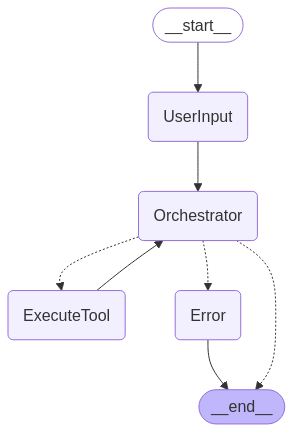

Graph visualization displayed.


In [12]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("UserInput", voice_interface_agent)
graph_builder.add_node("Orchestrator", orchestrator_agent)

tool_executor_node = ToolNode(available_tools)
graph_builder.add_node("ExecuteTool", tool_executor_node)

graph_builder.add_node("Error", error_node)

graph_builder.add_edge(START, "UserInput")
graph_builder.add_edge("UserInput", "Orchestrator")

graph_builder.add_conditional_edges(
    "Orchestrator",
    select_route,
    {
        "ExecuteTool": "ExecuteTool",
        "Error": "Error",
        END: END
    }
)

graph_builder.add_edge("ExecuteTool", "Orchestrator")

graph_builder.add_edge("Error", END)

app_graph = graph_builder.compile()

try:
    display(Image(app_graph.get_graph().draw_mermaid_png()))
    print("Graph visualization displayed.")
except Exception as e:
    print(f"Could not display graph visualization: {e}")

## Run the Agent System

In [13]:
config = {"recursion_limit": 15}

initial_state = {"messages": [], "final_response_generated": False}

try:
    final_state = app_graph.invoke(initial_state, config=config)
    print("\n--- Interaction Ended ---")
    print("\nFinal State:")
    pprint(final_state)
except Exception as e:
     print(f"\nAn error occurred during execution: {e}")

--- NODE: Voice Interface ---

An error occurred during execution: raw_input was called, but this frontend does not support input requests.
